# Домашнее задание 6

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 24 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_6

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

In [680]:
import numpy as np
import time
import random
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from matplotlib import pylab as plt
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import accuracy_score

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{2}x^T A x - b^T x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица с $L =1000$, $\mu = 1$, $d = 100$, $b$ - так же случайный вектор.

__(а)__ Для такой задачи симулируем итерацию координатного спуска (смотри семинар). 

Для такого метода подберите шаг $\gamma$ для наилучшей сходимости постройте график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число арифмитических операций при подсчете "градиента"). Постройте на этом же графике сходимость честного градиентного спуска c наилучшим шагом сходимости. Сделайте вывод о характере сходимости нового метода.

В данной задаче:

$$\nabla f(x) = \frac{1}{2} \left(A + A^T \right)x - b$$

В случае симметричной матрицы, которую мы генерируем:

$$\nabla f(x) = Ax - b$$

1. Градиентный спуск: $\gamma = \frac{2}{\mu + L}$ - теоретический шаг

2. Координатный спуск:

   $\gamma = \frac{1}{4Ld}$ - теоретический шаг

   $\gamma = \frac{Const}{4Ld}$
   
   $\gamma = \frac{Const}{k + 4Ld}$

In [386]:
# Генерация диагональной матрицы
def gen_matrix_diag(d, mu, L, s):
    np.random.seed(s)
    diag = mu + (L - mu) * np.random.sample(d)
    A = np.diag(diag)
    A[0][0] = L
    A[d - 1][d - 1] = mu
    return A


# Генерация матрицы
def gen_matrix(d, mu, L, s):
    np.random.seed(s)
    B = np.random.sample((d, d))
    Q, _ = np.linalg.qr(B)
    C = gen_matrix_diag(d, mu, L, s)
    A = Q @ C @ Q.T
    return A

In [569]:
# Целевая функция
def f(x):
    return 1/2 * x.T @ A @ x - b.T @ x

# Градиент функции
def grad_f(x):
    return A @ x - b

# Компонента градиента функции
def grad_f_i(x, i):
    return A[i] @ x - b[i]

In [793]:
def CSGD(grad_f, grad_f_i, x_0, gamma, iteration, dependence=True, b=1, epsilon=10**-7):
    
    x_now = np.copy(x_0)
    x_next = np.copy(x_0)
    errors = []
    
    errors.append(np.linalg.norm(grad_f(x_now), ord=2)**2)

    np.random.seed(2)
    
    for k in trange(iteration, colour='green'):
        
        np.random.seed(2 + k)
            
        if dependence:
            for i in random.sample(range(d), b):
                x_next[i] -= gamma(k) * grad_f_i(x_now, i)
        else:
            for j in range(b):
                i = np.random.randint(d)
                x_next[i] -= gamma(k) * grad_f_i(x_now, i)
            
        x_now = np.copy(x_next)
        
        errors.append(np.linalg.norm(grad_f(x_now), ord=2)**2)
        
        if errors[-1] < epsilon:
            break

    return x_now, errors

In [687]:
def GD(grad_f, x_0, gamma, iteration, epsilon=10**-7):
    
    x_now = x_0
    errors = []
    
    errors.append(np.linalg.norm(grad_f(x_now), ord=2)**2)
    
    for k in trange(iteration, colour='green'):
        
        x_next = x_now - gamma(k) * grad_f(x_now)
        x_now = x_next
        
        errors.append(np.linalg.norm(grad_f(x_now), ord=2)**2)
  
        if errors[-1] < epsilon:
            break
            
    return x_now, errors

In [578]:
s = 2
L = 1000
mu = 1
d = 100

np.random.seed(s)
A = gen_matrix(d, mu, L, s)
b = np.random.sample(d)
x_0 = np.random.sample(d)

In [399]:
def gd_theory_gamma(k):
    return 2 / (L + mu)

def csgd_theory_gamma(k):
    return 1 / (4 * L * d)

def csgd_const_gamma_1(k):
    return 500 / (4 * L * d)

def csgd_const_gamma_2(k):
    return 1000 / (4 * L * d)

def csgd_const_gamma_3(k):
    return 1500 / (4 * L * d)

def csgd_iter_gamma_1(k):
    return 500 / (k + 4 * L * d)

def csgd_iter_gamma_2(k):
    return 1000 / (k + 4 * L * d)

def csgd_iter_gamma_3(k):
    return 1500 / (k + 4 * L * d)

In [404]:
_, errors_1 = GD(grad_f, x_0, gd_theory_gamma, 5 * 10**5 // d)
_, errors_2 = CSGD(grad_f, grad_f_i, x_0, csgd_theory_gamma, 5 * 10**5)
_, errors_3 = CSGD(grad_f, grad_f_i, x_0, csgd_const_gamma_1, 5 * 10**5)
_, errors_4 = CSGD(grad_f, grad_f_i, x_0, csgd_const_gamma_2, 5 * 10**5)
_, errors_5 = CSGD(grad_f, grad_f_i, x_0, csgd_const_gamma_3, 5 * 10**5)
_, errors_6 = CSGD(grad_f, grad_f_i, x_0, csgd_iter_gamma_1, 5 * 10**5)
_, errors_7 = CSGD(grad_f, grad_f_i, x_0, csgd_iter_gamma_2, 5 * 10**5)
_, errors_8 = CSGD(grad_f, grad_f_i, x_0, csgd_iter_gamma_3, 5 * 10**5)

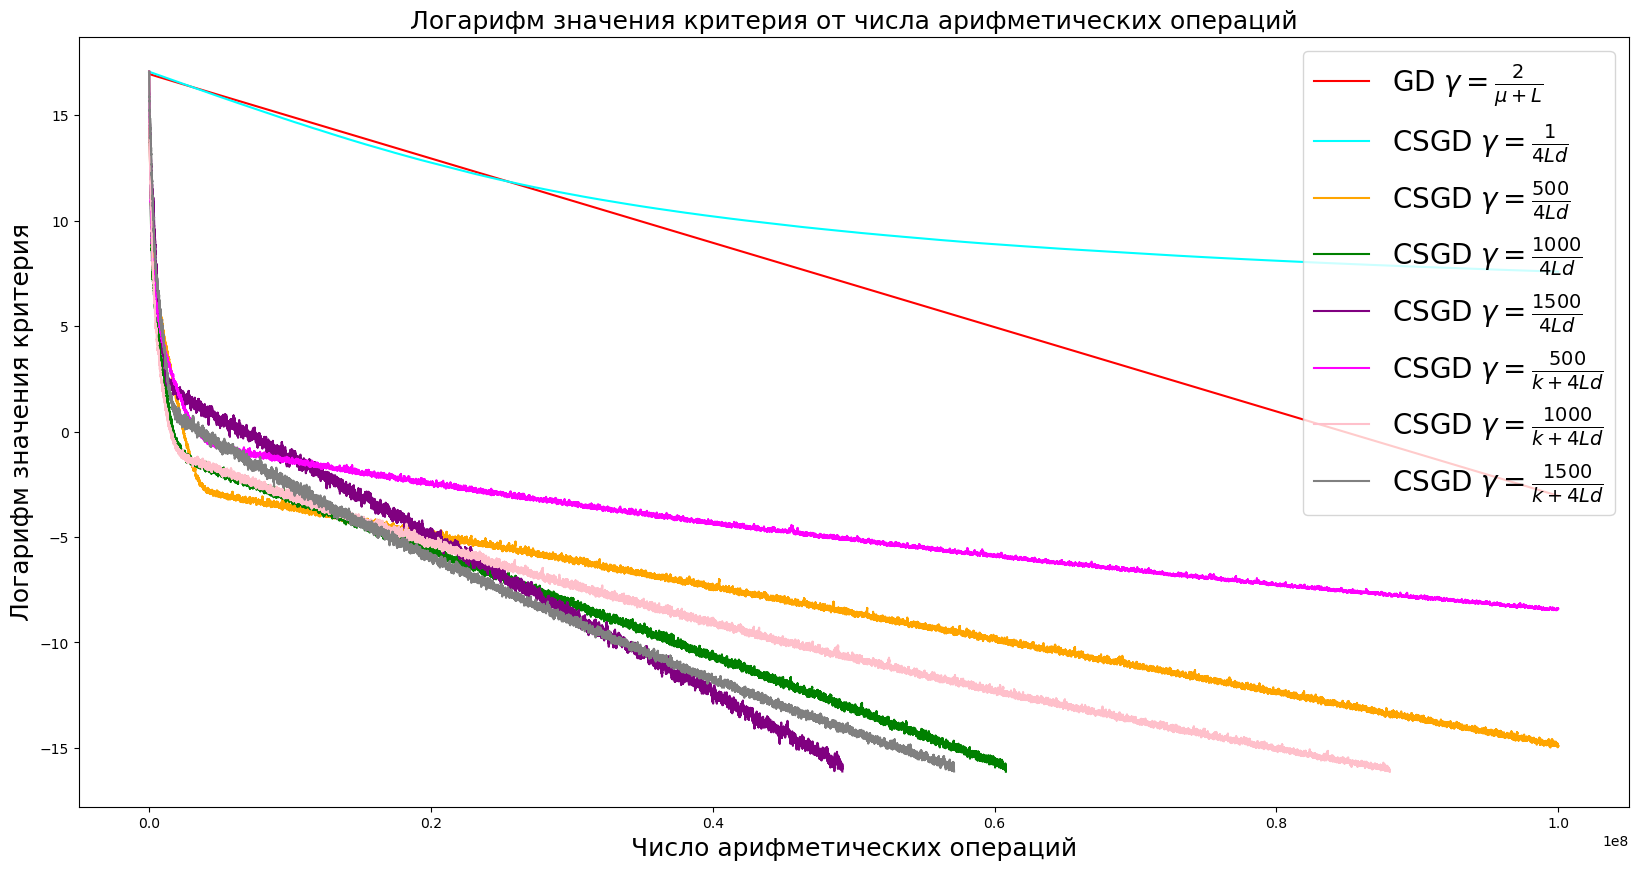

In [408]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(0, len(errors_1) * 2 * d**2, 2 * d**2)), np.log(errors_1), "red", label = r"GD $\gamma = \frac{2}{\mu + L}$")
plt.plot(np.array(range(0, len(errors_2) * 2 * d, 2 * d)), np.log(errors_2), "cyan", label = r"CSGD $\gamma = \frac{1}{4Ld}$")
plt.plot(np.array(range(0, len(errors_3) * 2 * d, 2 * d)), np.log(errors_3), "orange", label = r"CSGD $\gamma = \frac{500}{4Ld}$")
plt.plot(np.array(range(0, len(errors_4) * 2 * d, 2 * d)), np.log(errors_4), "green", label = r"CSGD $\gamma = \frac{1000}{4Ld}$")
plt.plot(np.array(range(0, len(errors_5) * 2 * d, 2 * d)), np.log(errors_5), "purple", label = r"CSGD $\gamma = \frac{1500}{4Ld}$")
plt.plot(np.array(range(0, len(errors_6) * 2 * d, 2 * d)), np.log(errors_6), "magenta", label = r"CSGD $\gamma = \frac{500}{k + 4Ld}$")
plt.plot(np.array(range(0, len(errors_7) * 2 * d, 2 * d)), np.log(errors_7), "pink", label = r"CSGD $\gamma = \frac{1000}{k + 4Ld}$")
plt.plot(np.array(range(0, len(errors_8) * 2 * d, 2 * d)), np.log(errors_8), "gray", label = r"CSGD $\gamma = \frac{1500}{k + 4Ld}$")
plt.title("Логарифм значения критерия от числа арифметических операций", fontsize = 18)
plt.xlabel("Число арифметических операций", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

Как мы видим, лучшего всего работает шаг $\gamma = \frac{1500}{4Ld}$, а теоретический шаг работает очень плохо.
Также всё (кроме CSGD с теоретическим $\gamma$) сходится лучше, чем обычный градиентный спуск с теоретическим коэфициентом сходимости.

Наилучшим $\gamma$, я думаю, является $\gamma = \frac{500}{4LD}$, так как слишком хорошую $\gamma$ брать нельзя - при изменениях матрицы, шумах может разойтись.

__(б)__ В координатном спуске можно брать несколько координат вместо одной. Модифицируйте координнатный спуск, исходя из этого, пробуя разное число координат $b = 1, 5, 10, 20$, а также разные способы сэмплирования: все координатны независимо или зависимо, чтобы не было повторений в батче. Постройте графики аналогичные пункту (а). Сделайте вывод.

In [580]:
_, errors_9 = GD(grad_f, x_0, gd_theory_gamma, 5 * 10**5 // d)
_, errors_10 = CSGD(grad_f, grad_f_i, x_0, csgd_const_gamma_1, 5 * 10**5, b=1)
_, errors_11 = CSGD(grad_f, grad_f_i, x_0, csgd_const_gamma_1, 5 * 2 * 10**4, b=5)
_, errors_12 = CSGD(grad_f, grad_f_i, x_0, csgd_const_gamma_1, 5 * 10**4, b=10)
_, errors_13 = CSGD(grad_f, grad_f_i, x_0, csgd_const_gamma_1, 5 * 5 * 10**3, b=20)

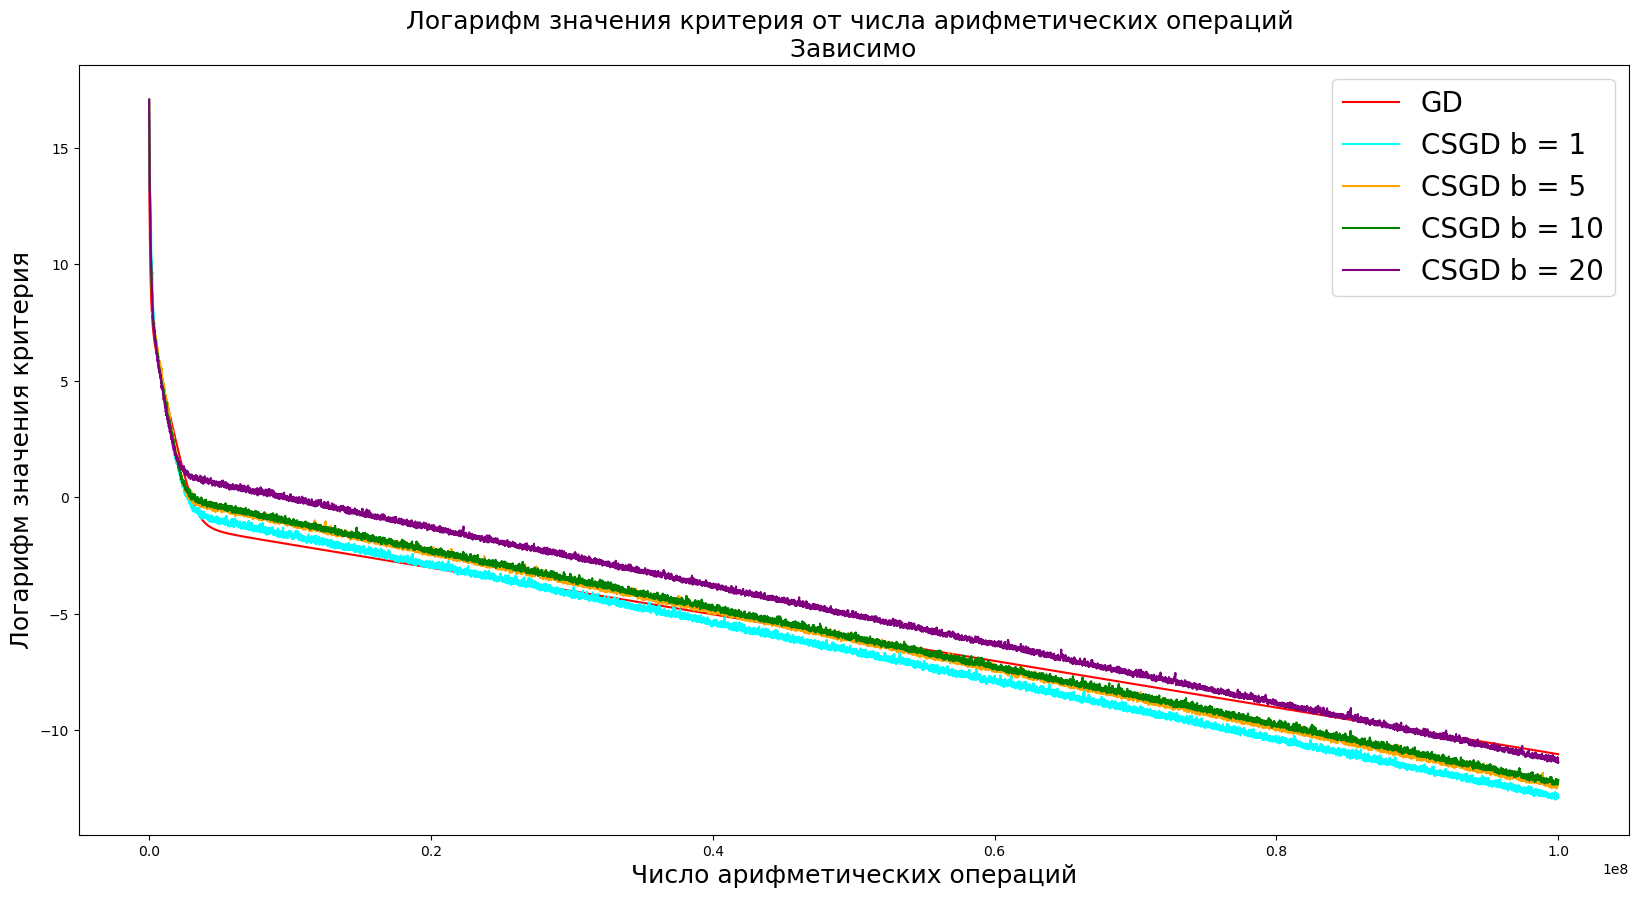

In [581]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(0, len(errors_9) * 2 * d**2, 2 * d**2)), np.log(errors_9), "red", label = "GD")
plt.plot(np.array(range(0, len(errors_10) * 2 * d, 2 * d)), np.log(errors_10), "cyan", label = "CSGD b = 1")
plt.plot(np.array(range(0, len(errors_11) * 10 * d, 10 * d)), np.log(errors_11), "orange", label = "CSGD b = 5")
plt.plot(np.array(range(0, len(errors_12) * 20 * d, 20 * d)), np.log(errors_12), "green", label = "CSGD b = 10")
plt.plot(np.array(range(0, len(errors_13) * 40 * d, 40 * d)), np.log(errors_13), "purple", label = "CSGD b = 20")
plt.title("Логарифм значения критерия от числа арифметических операций \n Зависимо ", fontsize = 18)
plt.xlabel("Число арифметических операций", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

In [411]:
_, errors_14 = GD(grad_f, x_0, gd_theory_gamma, 5 * 10**5 // d)
_, errors_15 = CSGD(grad_f, grad_f_i, x_0, csgd_const_gamma_1, 5 * 10**5, dependence=False, b=1)
_, errors_16 = CSGD(grad_f, grad_f_i, x_0, csgd_const_gamma_1, 5 * 2 * 10**4, dependence=False, b=5)
_, errors_17 = CSGD(grad_f, grad_f_i, x_0, csgd_const_gamma_1, 5 * 10**4, dependence=False, b=10)
_, errors_18 = CSGD(grad_f, grad_f_i, x_0, csgd_const_gamma_1, 5 * 5 * 10**3, dependence=False, b=20)

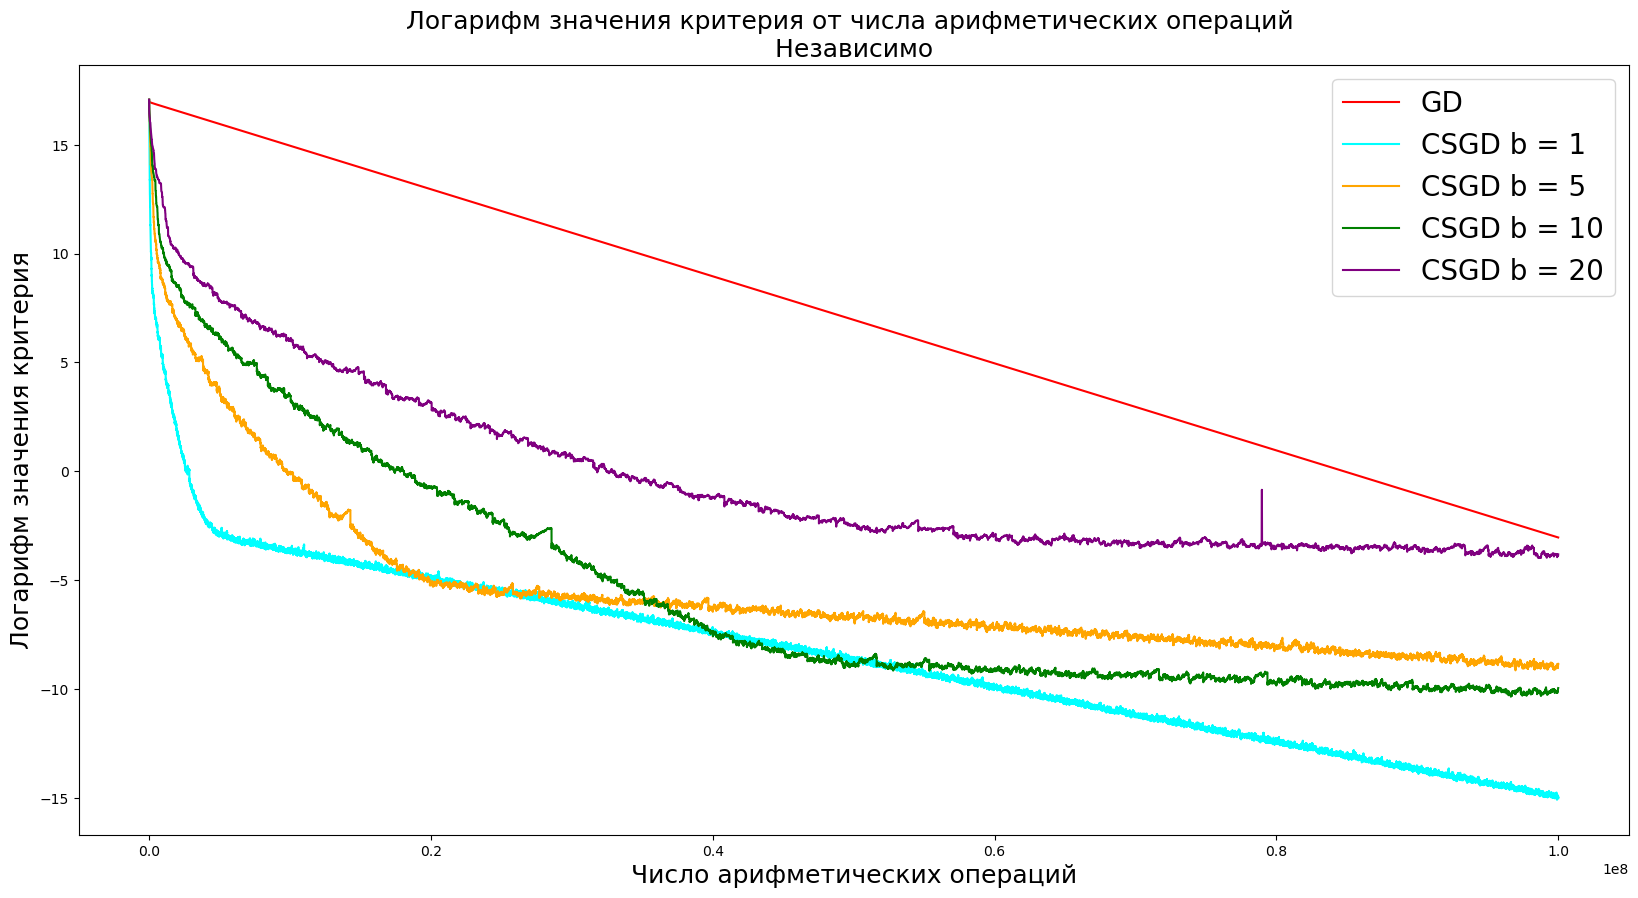

In [412]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(0, len(errors_14) * 2 * d**2, 2 * d**2)), np.log(errors_14), "red", label = "GD")
plt.plot(np.array(range(0, len(errors_15) * 2 * d, 2 * d)), np.log(errors_15), "cyan", label = "CSGD b = 1")
plt.plot(np.array(range(0, len(errors_16) * 10 * d, 10 * d)), np.log(errors_16), "orange", label = "CSGD b = 5")
plt.plot(np.array(range(0, len(errors_17) * 20 * d, 20 * d)), np.log(errors_17), "green", label = "CSGD b = 10")
plt.plot(np.array(range(0, len(errors_18) * 40 * d, 40 * d)), np.log(errors_18), "purple", label = "CSGD b = 20")
plt.title("Логарифм значения критерия от числа арифметических операций \n Независимо ", fontsize = 18)
plt.xlabel("Число арифметических операций", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

Как мы видим независимое сэпмлирование координат показало себя хуже, чем зависимое, причем чем больше координат, тем хуже.
При зависимом сэплировании координат мы видим, что они показали себя также хорошо, но чем больше координат, тем показания хуже.

## Задача 2

Рассмотрим задачу линейной регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Оцените $\mu$ и $L$ для данной задачи. 

В домашнем задниии 1 мы показали, что:

$$\mu = \frac{1}{2} \lambda_{min} (A + A^T) = \frac{2}{n} \lambda_{min} X^TX$$

$$L = \frac{1}{2} \lambda_{max}\left(A + A^T \right) = \frac{2}{n} \lambda_{max} X^TX$$

In [628]:
dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, d = X.shape

In [629]:
seed = 4

np.random.seed(seed)
np.random.shuffle(X)
X_train = X[:(n*4) // 5]
X_test = X[(n*4) // 5:]

np.random.seed(seed)
np.random.shuffle(y)
y_train = y[:(n*4) // 5]
y_test = y[(n*4) // 5:]

In [630]:
pr, _ = np.linalg.eigh(2 / X_train.shape[0] * X_train.T @ X_train)
mu = np.min(pr)
L = np.max(pr)
print("mu =", round(mu, 16))
print("L =", round(L, 2))

mu = -6e-16
L = 20.69


Из-за машинной точности мы получили $\mu < 0$, но близкой к нулю, поэтому $\mu \approx 0$.

__(б)__ Реализуйте координатный SGD, SEGA для задачи линейно регрессии. Каким будете брать $b$? Как будете выбирать шаг и другие параметры методов?

1. CSGD: параметры возьмем из первого задания $b = 1$ и $\gamma = \frac{500}{4Ld}$.

2. SEGA: проведем такие же эксперименты как в первом задании:

$\gamma = \frac{1}{24Ld}$ - теоретический шаг

$\gamma = \frac{Const}{24Ld}$
   
$\gamma = \frac{Const}{k + 24Ld}$

In [681]:
#Целевая функция
def f(w):
    return 1 / F.shape[0] * np.linalg.norm(F @ w - a, ord = 2)**2

#Градиент функции 
def grad_f(w):
    return 2 / F.shape[0] * (F.T @ (F @ w - a))

#Частичный градиент
def grad_f_i(w, i):
    return 2 / F.shape[0] * ((F.T @ F)[i] @ w - (F.T @ a)[i])

#prox - функция
def prox(w, gamma):
    return max(1 - gamma * L / (1000 * np.linalg.norm(w, ord=2)), 0) * w

In [682]:
F = X_train
a = y_train

seed = 3
np.random.seed(s)
w_0 = np.random.sample(d)

In [794]:
def CSGD(grad_f, grad_f_i, x_0, gamma, iteration, dependence=True, b=1, epsilon=10**-7):
    
    x_now = np.copy(x_0)
    x_next = np.copy(x_0)
    errors = []
    times = [0]
    numbers = [0]

    start_time = time.time()
    
    errors.append(np.linalg.norm(grad_f(x_now), ord=2)**2)

    np.random.seed(2)
    
    for k in trange(iteration, colour='green'):
        
        np.random.seed(2 + k)
            
        if dependence:
            for i in random.sample(range(d), b):
                x_next[i] -= gamma(k) * grad_f_i(x_now, i)
        else:
            for j in range(b):
                i = np.random.randint(d)
                x_next[i] -= gamma(k) * grad_f_i(x_now, i)
        
        x_now = np.copy(x_next)
            
        errors.append(np.linalg.norm(grad_f(x_now), ord=2)**2)
        times.append(time.time() - start_time)
        numbers.append(numbers[-1] + 2 * b * d)
        
        if errors[-1] < epsilon:
            break

    return x_now, errors, times, numbers    

In [795]:
def SEGA(grad_f, grad_f_i, x_0, gamma, iteration, dependence=True, b=1, epsilon=10**-7):
    
    x_now = x_0
    h_now = np.zeros(len(x_0))
    h_next = np.zeros(len(x_0))
    g = np.zeros(len(x_0))
    errors = []
    times = [0]
    numbers = [0]

    start_time = time.time()
    
    errors.append(np.linalg.norm(grad_f(x_now), ord=2)**2)

    np.random.seed(2)
    
    for k in trange(iteration, colour='green'):
        
        np.random.seed(2 + k)
          
        if dependence:
            for i in random.sample(range(d), b):
                grad = grad_f_i(x_now, i)
                h_next[i] = np.copy(grad)
                g[i] = d * (grad - h_now[i])
                g += h_now
        else:
            for j in range(b):
                i = np.random.randint(d)
                grad = grad_f_i(x_now, i)
                h_next[i] = np.copy(grad)
                g[i] = d * (grad - h_now[i])
                g += h_now
        
        h_now = np.copy(h_next)
        x_next = prox(x_now - gamma(k) * g, gamma(k))
        x_now = x_next

        errors.append(np.linalg.norm(grad_f(x_now), ord=2)**2)
        times.append(time.time() - start_time)
        numbers.append(numbers[-1] + 2 * b * d)
        
        if errors[-1] < epsilon:
            break

    return x_now, errors, times, numbers

In [796]:
def gd_theory_gamma(k):
    return 1 / L

def sega_theory_gamma(k):
    return 1 / (24 * L * d)

def sega_const_gamma_1(k):
    return 0.8 / (24 * L * d)

def sega_const_gamma_2(k):
    return 0.6 / (24 * L * d)

def sega_const_gamma_3(k):
    return 0.4 / (24 * L * d)

def sega_iter_gamma_1(k):
    return 0.8 / (k + 24 * L * d)

def sega_iter_gamma_2(k):
    return 0.5 / (k + 24 * L * d)

def sega_iter_gamma_3(k):
    return 0.3 / (k + 24 * L * d)

In [820]:
_, errors_1 = GD(grad_f, w_0, gd_theory_gamma,  5 * 10**3 // d)
_, errors_2, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_theory_gamma, 10**3, b=8)
_, errors_3, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_const_gamma_1, 10**3, b=8)
_, errors_4, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_const_gamma_2, 10**3, b=8)
_, errors_5, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_const_gamma_3, 10**3, b=8)
_, errors_6, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_iter_gamma_1, 10**3, b=8)
_, errors_7, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_iter_gamma_2, 10**3, b=8)
_, errors_8, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_iter_gamma_3, 10**3, b=8)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

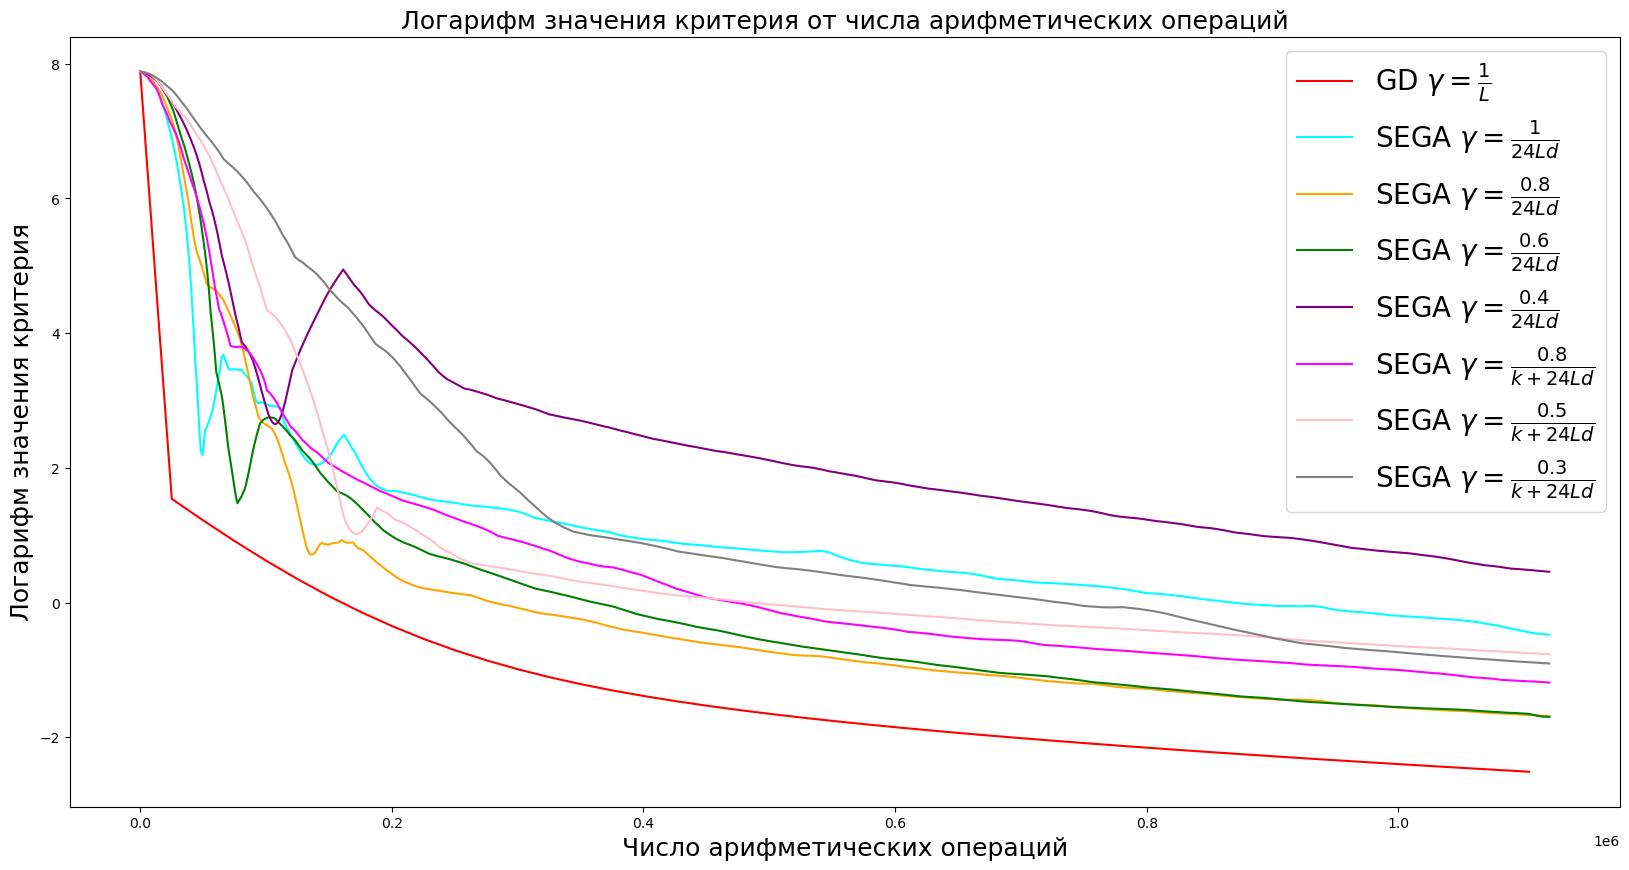

In [821]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(0, len(errors_1) * 2 * d * d, 2 * d * d)), np.log(errors_1), "red", label = r"GD $\gamma = \frac{1}{L}$")
plt.plot(np.array(range(0, len(errors_2) * 2 * d * 5, 2 * d * 5)), np.log(errors_2), "cyan", label = r"SEGA $\gamma = \frac{1}{24Ld}$")
plt.plot(np.array(range(0, len(errors_3) * 2 * d * 5, 2 * d * 5)), np.log(errors_3), "orange", label = r"SEGA $\gamma = \frac{0.8}{24Ld}$")
plt.plot(np.array(range(0, len(errors_4) * 2 * d * 5, 2 * d * 5)), np.log(errors_4), "green", label = r"SEGA $\gamma = \frac{0.6}{24Ld}$")
plt.plot(np.array(range(0, len(errors_5) * 2 * d * 5, 2 * d * 5)), np.log(errors_5), "purple", label = r"SEGA $\gamma = \frac{0.4}{24Ld}$")
plt.plot(np.array(range(0, len(errors_6) * 2 * d * 5, 2 * d * 5)), np.log(errors_6), "magenta", label = r"SEGA $\gamma = \frac{0.8}{k + 24Ld}$")
plt.plot(np.array(range(0, len(errors_7) * 2 * d * 5, 2 * d * 5)), np.log(errors_7), "pink", label = r"SEGA $\gamma = \frac{0.5}{k + 24Ld}$")
plt.plot(np.array(range(0, len(errors_8) * 2 * d * 5, 2 * d * 5)), np.log(errors_8), "gray", label = r"SEGA $\gamma = \frac{0.3}{k + 24Ld}$")
plt.title("Логарифм значения критерия от числа арифметических операций", fontsize = 18)
plt.xlabel("Число арифметических операций", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

Пришлось взять $b = 8$, так как иначе очень сильные колебания.

Как мы видим, лучшего всего работает шаг $\gamma = \frac{0.8}{24Ld}$, его и возьмём.

In [800]:
_, errors_9 = GD(grad_f, w_0, gd_theory_gamma, 5 * 10**4 // d)
_, errors_10, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_const_gamma_1, 5 * 2 * 10**3, b=5)
_, errors_11, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_const_gamma_1, 5 * 10**3, b=10)
_, errors_12, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_const_gamma_1, 5 * 10**4 // 15, b=15)
_, errors_13, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_const_gamma_1, 5 * 5 * 10**2, b=20)

  0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/3333 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

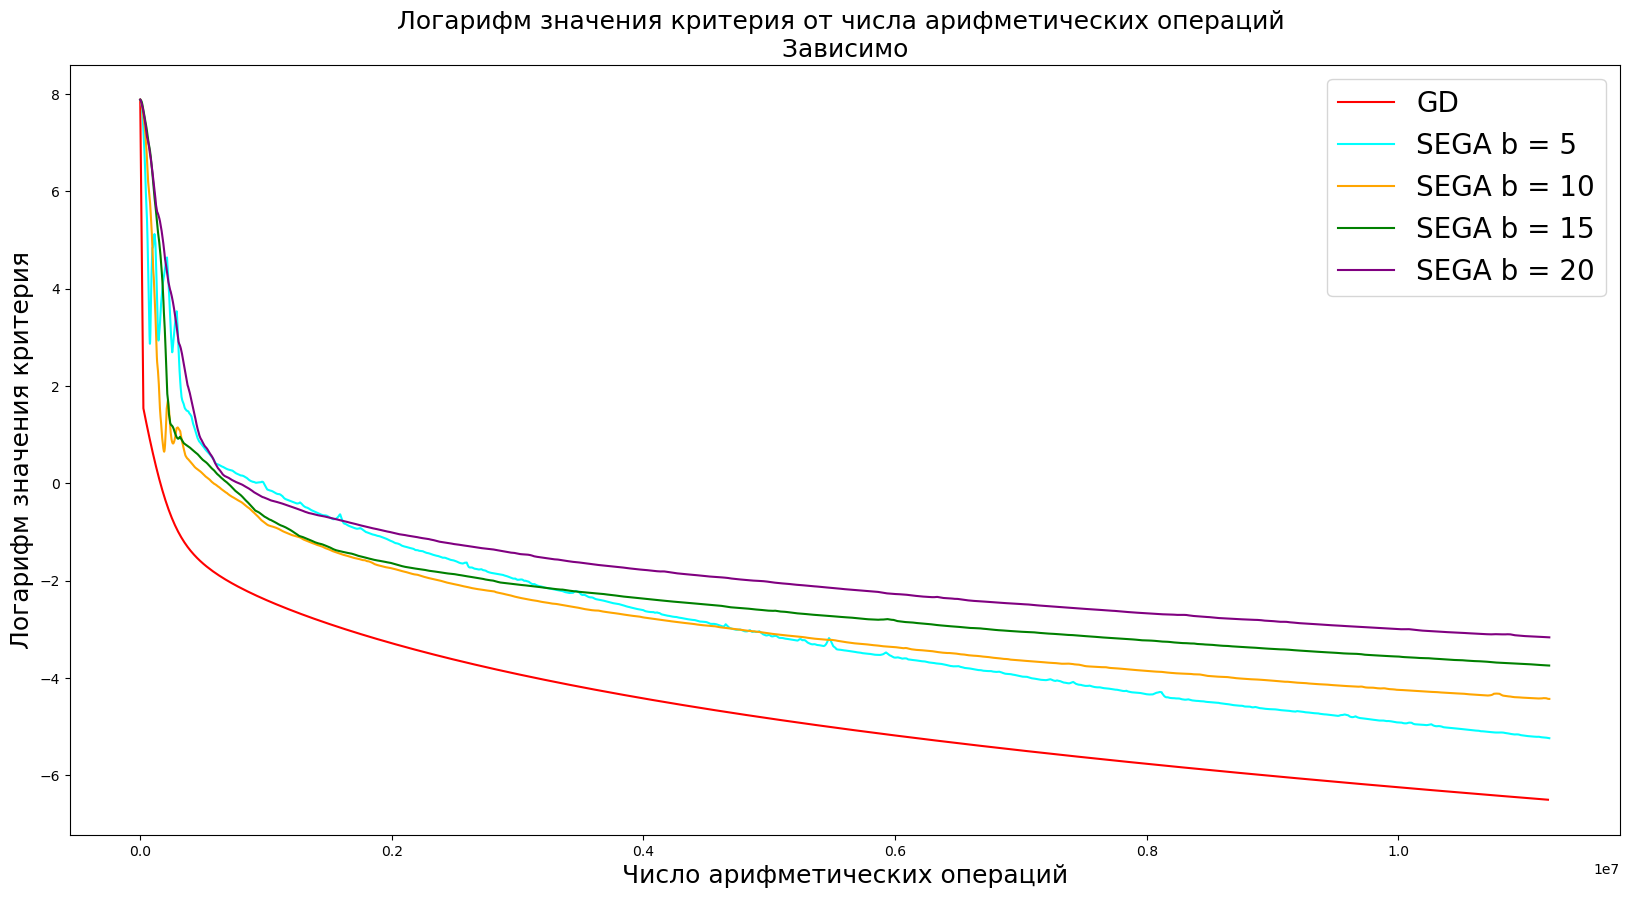

In [801]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(0, len(errors_9) * 2 * d**2, 2 * d**2)), np.log(errors_9), "red", label = "GD")
plt.plot(np.array(range(0, len(errors_10) * 10 * d, 10 * d)), np.log(errors_10), "cyan", label = "SEGA b = 5")
plt.plot(np.array(range(0, len(errors_11) * 20 * d, 20 * d)), np.log(errors_11), "orange", label = "SEGA b = 10")
plt.plot(np.array(range(0, len(errors_12) * 30 * d, 30 * d)), np.log(errors_12), "green", label = "SEGA b = 15")
plt.plot(np.array(range(0, len(errors_13) * 40 * d, 40 * d)), np.log(errors_13), "purple", label = "SEGA b = 20")
plt.title("Логарифм значения критерия от числа арифметических операций \n Зависимо ", fontsize = 18)
plt.xlabel("Число арифметических операций", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

In [802]:
_, errors_14 = GD(grad_f, w_0, gd_theory_gamma, 5 * 10**4 // d)
_, errors_15, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_const_gamma_1, 5 * 2 * 10**3, dependence=False, b=1)
_, errors_16, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_const_gamma_1, 5 * 10**3, dependence=False, b=5)
_, errors_17, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_const_gamma_1, 5 * 10**4 // 15, dependence=False, b=10)
_, errors_18, _, _ = SEGA(grad_f, grad_f_i, w_0, sega_const_gamma_1, 5 * 5 * 10**2, dependence=False, b=20)

  0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/3333 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

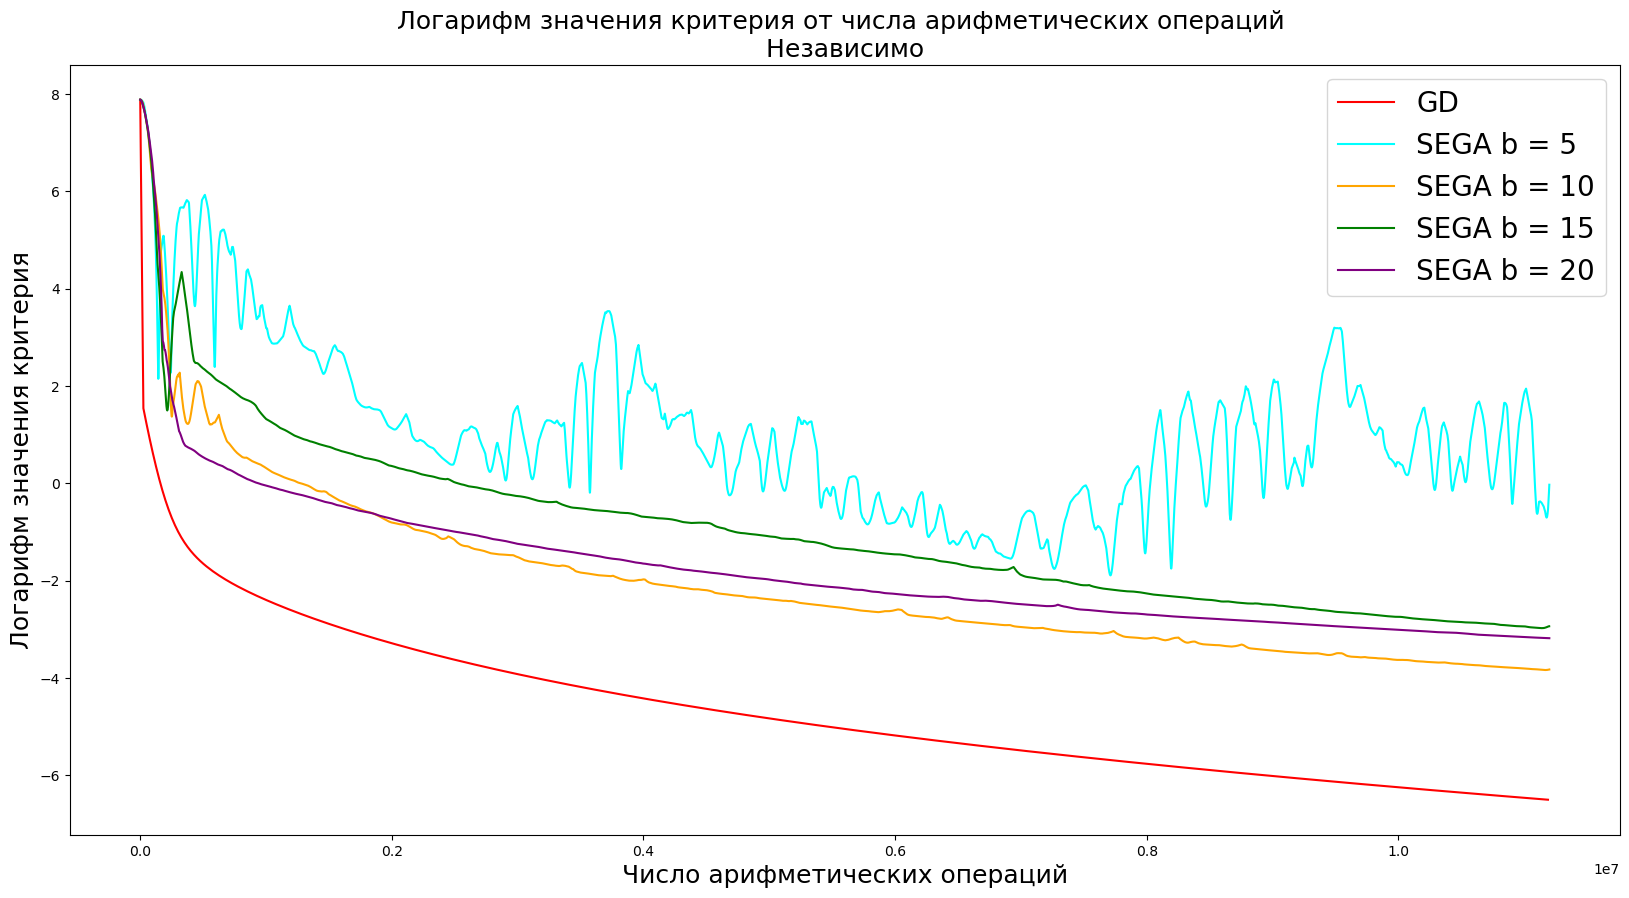

In [803]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(0, len(errors_14) * 2 * d**2, 2 * d**2)), np.log(errors_14), "red", label = "GD")
plt.plot(np.array(range(0, len(errors_15) * 10 * d, 10 * d)), np.log(errors_15), "cyan", label = "SEGA b = 5")
plt.plot(np.array(range(0, len(errors_16) * 20 * d, 20 * d)), np.log(errors_16), "orange", label = "SEGA b = 10")
plt.plot(np.array(range(0, len(errors_17) * 30 * d, 30 * d)), np.log(errors_17), "green", label = "SEGA b = 15")
plt.plot(np.array(range(0, len(errors_18) * 40 * d, 40 * d)), np.log(errors_18), "purple", label = "SEGA b = 20")
plt.title("Логарифм значения критерия от числа арифметических операций \n Независимо ", fontsize = 18)
plt.xlabel("Число арифметических операций", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

Как мы видим, хорошо брать $b$ около 10.

__(в)__ Постройте графики сравнения всех методов: по оси $x$ используйте время или количество арифметических операций, по оси $y$ - $\|\nabla f(x^k)\|$ или точность на тесте. Таким образом, всего 4 графика. Сделайте сравнение и вывод.

In [838]:
answer_1, errors_1, times_1, numbers_1 = CSGD(grad_f, grad_f_i, w_0, csgd_const_gamma_1, 50000)
answer_2, errors_2, times_2, numbers_2 = SEGA(grad_f, grad_f_i, w_0, sega_const_gamma_2, 50000, b=8)

  0%|          | 0/50000 [00:00<?, ?it/s]

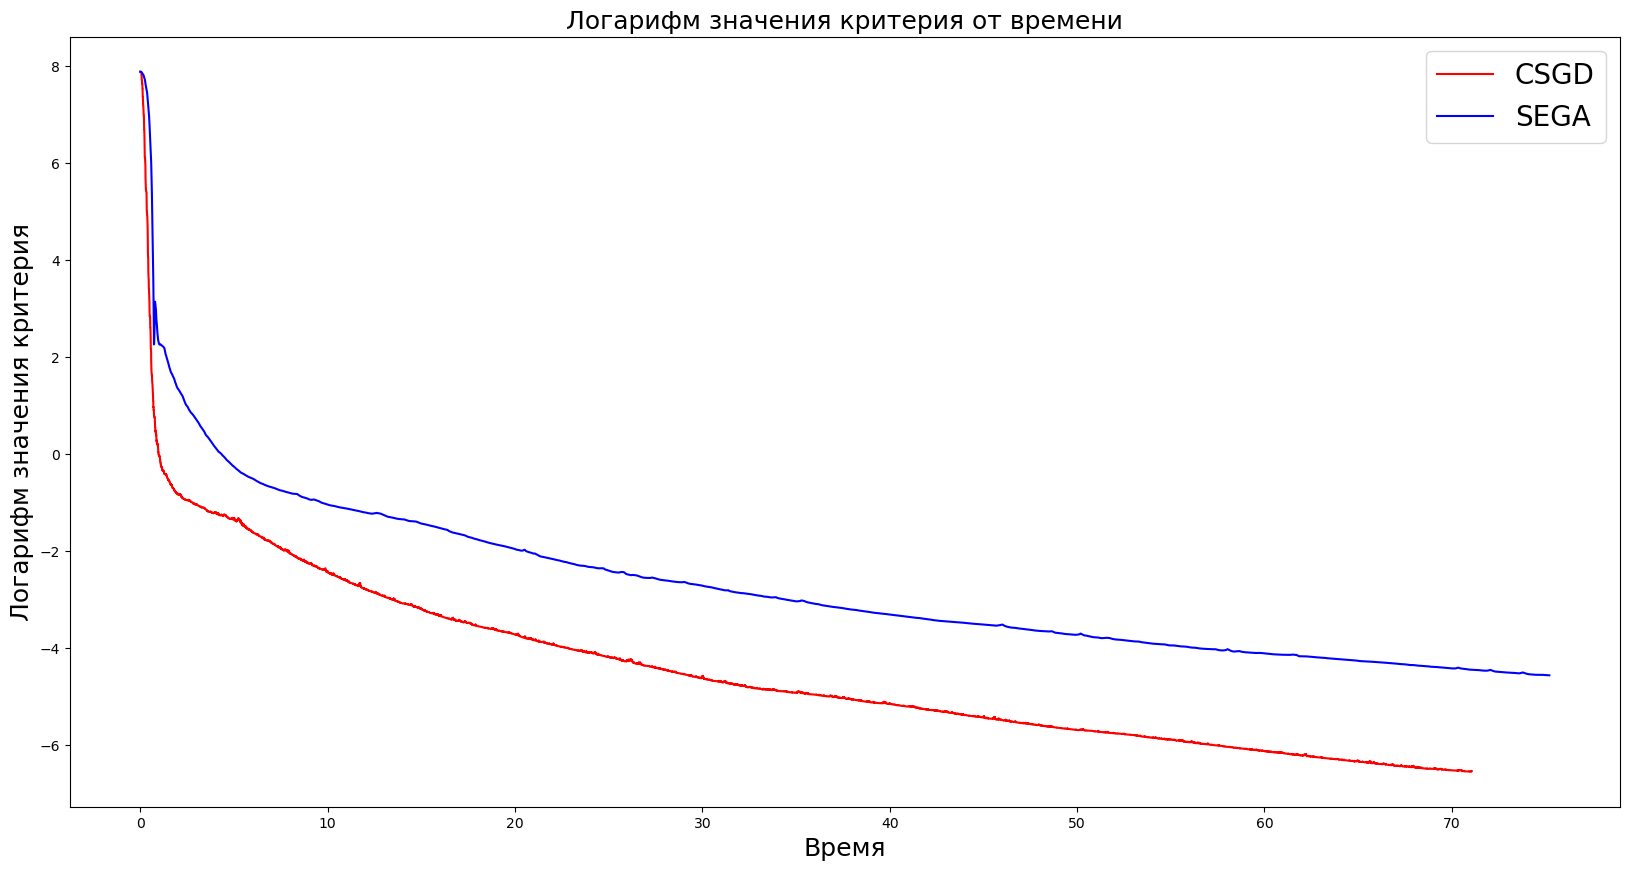

In [853]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(times_1), np.log(errors_1), "red", label = "CSGD")
plt.plot(np.array(times_2[0:8000]), np.log(errors_2[0:8000]), "blue", label = "SEGA")
plt.title("Логарифм значения критерия от времени", fontsize = 18)
plt.xlabel("Время", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

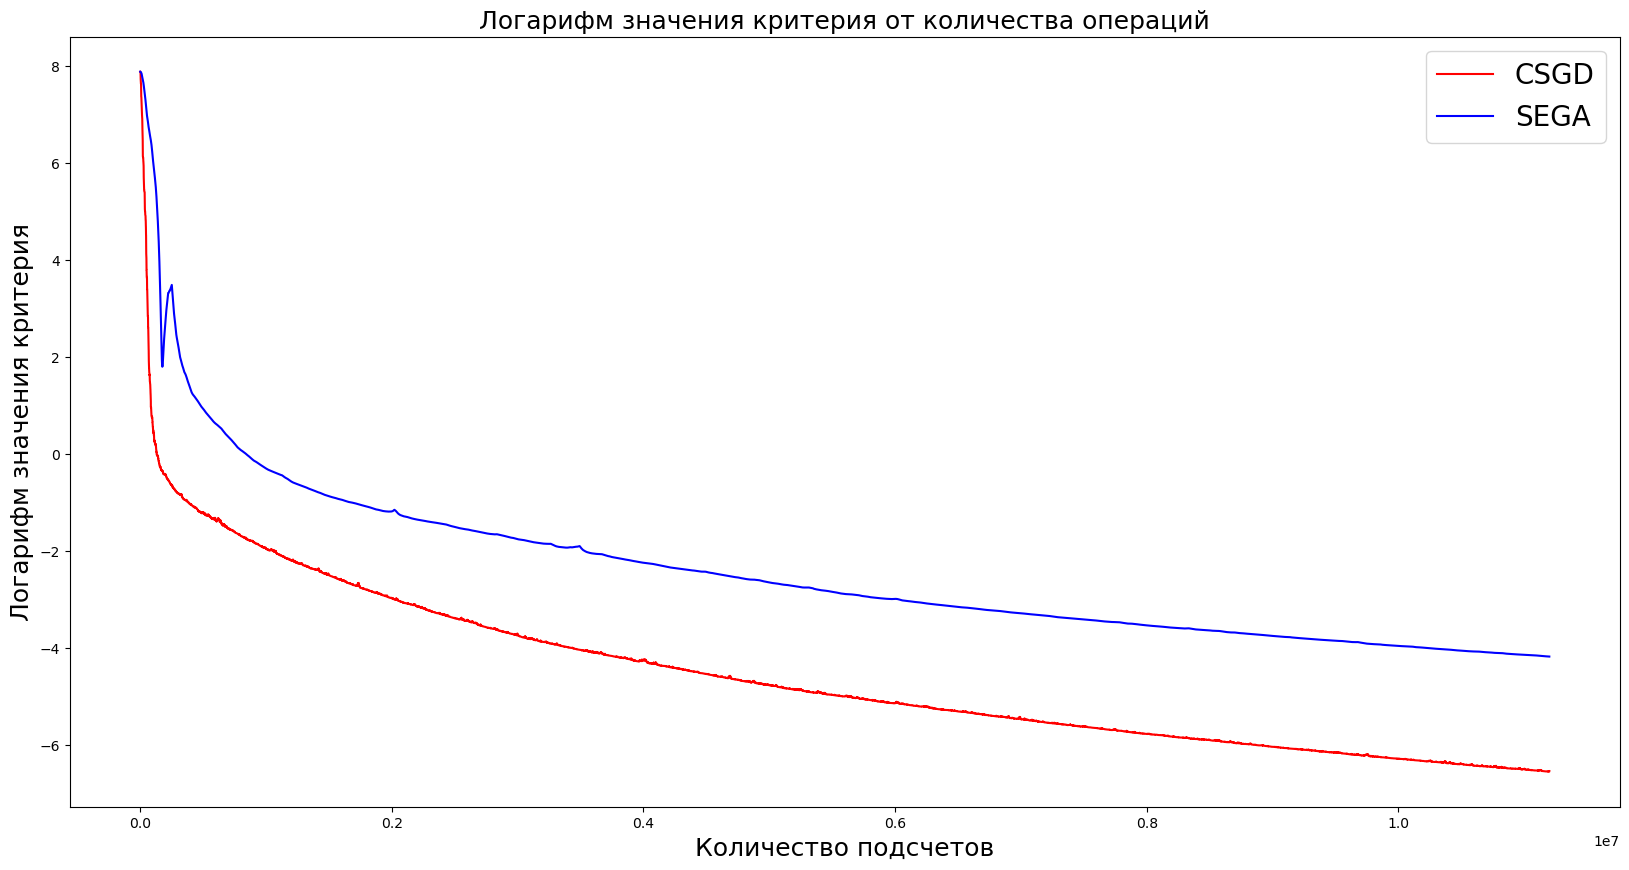

In [824]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(numbers_1), np.log(errors_1), "red", label = "CSGD")
plt.plot(np.array(numbers_2), np.log(errors_2), "blue", label = "SEGA")
plt.title("Логарифм значения критерия от количества операций", fontsize = 18)
plt.xlabel("Количество подсчетов", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

In [830]:
def accuracy(y_test, X_test, method, grad_f, grad_f_i, x_0, gamma, iteration, step, b=1):
    accuracy = []
    for i in tqdm(range(1, iteration + 1, step), colour='green'):
        w, error, _, _ = method(grad_f, grad_f_i, x_0, gamma, i, b)
        y_pred = np.round(X_test @ w)
        accuracy.append(accuracy_score(y_test, y_pred))
    return accuracy

In [835]:
accuracy_1 = accuracy(y_test, X_test, CSGD, grad_f, grad_f_i, w_0, csgd_const_gamma_1, 50000, 5000)
accuracy_2 = accuracy(y_test, X_test, SEGA, grad_f, grad_f_i, w_0, sega_const_gamma_2, 50000, 5000, b=8)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/15001 [00:00<?, ?it/s]

  0%|          | 0/20001 [00:00<?, ?it/s]

  0%|          | 0/25001 [00:00<?, ?it/s]

  0%|          | 0/30001 [00:00<?, ?it/s]

  0%|          | 0/35001 [00:00<?, ?it/s]

  0%|          | 0/40001 [00:00<?, ?it/s]

  0%|          | 0/45001 [00:00<?, ?it/s]

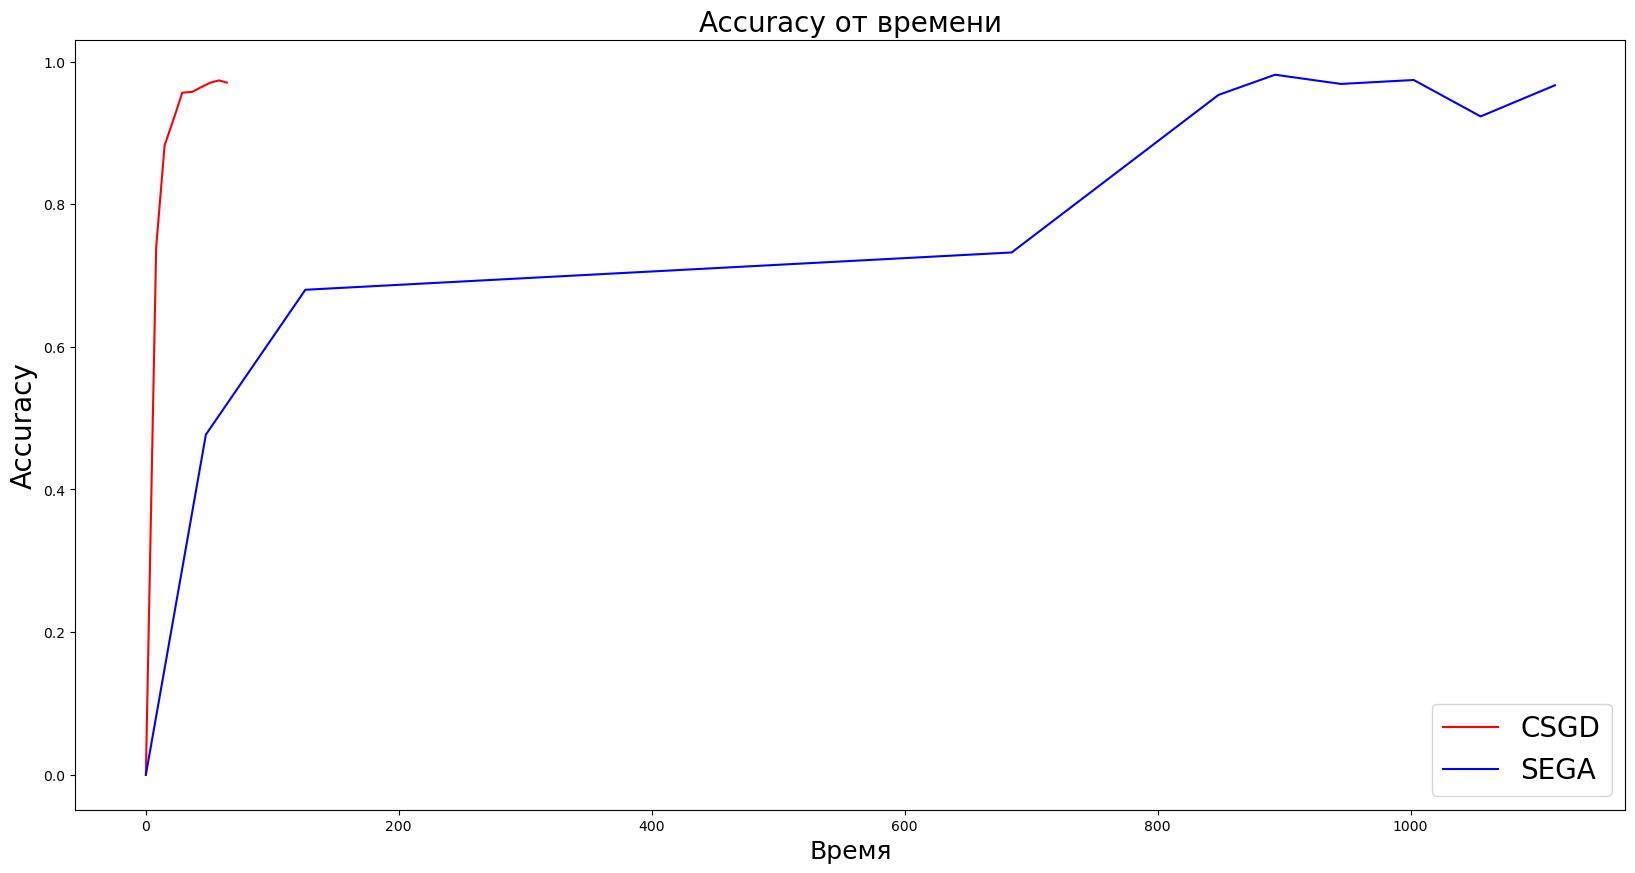

In [841]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(times_1[1::5000]), accuracy_1, "red", label = "CSGD")
plt.plot(np.array(times_2[1::5000]), accuracy_2, "blue", label = "SEGA")
plt.title("Accuracy от времени", fontsize = 20)
plt.xlabel("Время", fontsize = 18)
plt.ylabel("Accuracy", fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

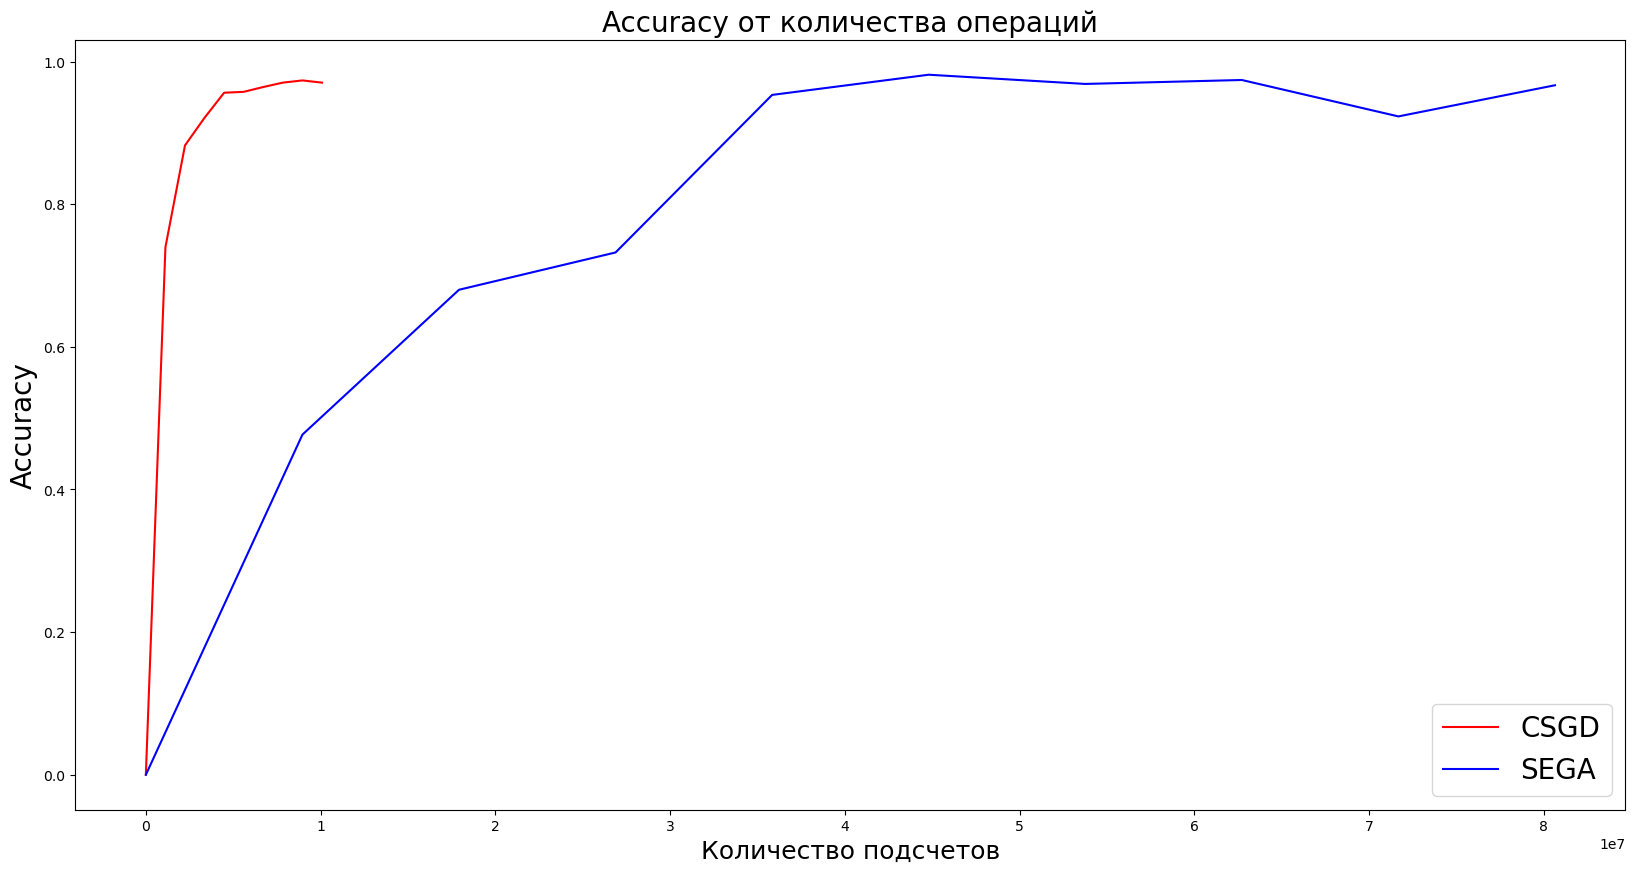

In [854]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(numbers_1[1::5000]), accuracy_1, "red", label = "CSGD")
plt.plot(np.array(numbers_2[1::5000]), accuracy_2, "blue", label = "SEGA")
plt.title("Accuracy от количества операций", fontsize = 20)
plt.xlabel("Количество подсчетов", fontsize = 18)
plt.ylabel("Accuracy", fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

На данной задаче:
1. CSGD работает лучше, чем SEGA.
2. Получились достойные результаты, с меньшей затратой операций.

__Бонусные пункты__

__(г)__ Попробуйте объеденить подходы SAGA/SVRG/L-SVRG и координатный SGD/SEGA (т.е. могут получиться пары SAGA + координатный, SVRG + SEGA и еще четыре других). Вам достаточно выбрать одну пару. Как при этом будет выглядеть итерация метода (запишите в явном виде)? Докажите сходимость данного подхода для $\mu$-сильно выпуклой $f$ и $L$-гладкой $f_i$.

In [ ]:
#ответ

__(д)__ Реализуйте новый метод. Сравните его с двумя методами, которые были взяты за базу, на задаче линейной регресии. Способы сравнения методов придумайте самостоятельно. Сделайте вывод.

In [ ]:
#ответ